# Анализ пользовательского поведения в мобильном приложении


Имеется проект - онлайн магазин продуктов питания. Сервис работает через свое приложение.

Нужно провести анализ поведения пользователей данного приложения: как пользователи доходят до этапа совершения покупки, какая доля пользователей доходят до совершения заказа, и т.д.

Далее необходимо проанализировать проведенный А/А/В-тест, где имеется 2 контрольных группы и одна экспериментальная. Сам эксперимент заключается в смене шрифта всего приложения.

Для проведения данного исследования у нас есть запись логов за определенный отрезок времени.Каждя запись в логе - это действия пользователя, о которых нам известно название этого события, время свершения события, индивидуальный номер пользователя, совершившего данное действие и номер группы, в которой числитя пользователь.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных,-подготовка-к-анализу" data-toc-modified-id="Загрузка-данных,-подготовка-к-анализу-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных, подготовка к анализу</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение данных</a></span><ul class="toc-item"><li><span><a href="#События." data-toc-modified-id="События.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>События.</a></span></li><li><span><a href="#Пользователи." data-toc-modified-id="Пользователи.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Пользователи.</a></span></li><li><span><a href="#Время." data-toc-modified-id="Время.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Время.</a></span></li></ul></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Обработка-результатов-эксперимента." data-toc-modified-id="Обработка-результатов-эксперимента.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обработка результатов эксперимента.</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

##  Загрузка данных, подготовка к анализу

In [1]:
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import plotly.express as px
plt.style.use(['bmh', "tableau-colorblind10"])
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth

In [46]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t',)
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Итак, данные которые мы имеем:
1. EventName — название события;
2. DeviceIDHash — уникальный идентификатор пользователя;
3. EventTimestamp — время события;
4. ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [3]:
def common_data(data):
    print('{: ^40}'.format('Общая информация:'))
    display(data.info())
    print()
    print('{: ^40}'.format('Количество пропущенных значений:'))
    display(data.isna().sum())
    print()
    print('{: ^40}'.format('Количество дубликатов:'))
    print(data.duplicated().sum())
    print()
    print('{: ^40}'.format('Числовое описание данных:'))
    display(data.describe())
    
common_data(df)

           Общая информация:            
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None


    Количество пропущенных значений:    


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


         Количество дубликатов:         
413

       Числовое описание данных:        


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


Немного преобразуем наши данные, а именно:
1. приведем названия столбцов к ниженему регистру;
2. переименуем для удобства;
3. приведем данные к нужному формату;
4. избавимся от дубликатов

In [4]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'deviceidhash':'uid', 'eventtimestamp':'event_time', 'expid':'group'})
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
df = df.drop_duplicates()

In [5]:
df.head()

,eventname,uid,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Выделим также в отдельные столбцы дату и время.

In [6]:
df['event_month'] = df['event_time'].astype('datetime64[M]')
df['event_date'] = df['event_time'].dt.date
df['event_date'] = pd.to_datetime(df['event_date'])
df['hours'] = df['event_time'].dt.strftime('%Y-%m-%d %H')

df.head()

,eventname,uid,event_time,group,event_month,event_date,hours
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-01,2019-07-25,2019-07-25 04
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-01,2019-07-25,2019-07-25 11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-01,2019-07-25,2019-07-25 11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-01,2019-07-25,2019-07-25 11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-01,2019-07-25,2019-07-25 11


Проверим датасет еще раз после всех проведенных нами манипуляций. 

In [7]:
common_data(df)

           Общая информация:            
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 7 columns):
eventname      243713 non-null object
uid            243713 non-null int64
event_time     243713 non-null datetime64[ns]
group          243713 non-null int64
event_month    243713 non-null datetime64[ns]
event_date     243713 non-null datetime64[ns]
hours          243713 non-null object
dtypes: datetime64[ns](3), int64(2), object(2)
memory usage: 14.9+ MB


None


    Количество пропущенных значений:    


eventname      0
uid            0
event_time     0
group          0
event_month    0
event_date     0
hours          0
dtype: int64


         Количество дубликатов:         
0

       Числовое описание данных:        


,uid,group
count,2.437130e+05,243713.000000
mean,4.627963e+18,247.022161
std,2.642723e+18,0.824420
min,6.888747e+15,246.000000
25%,2.372212e+18,246.000000
50%,4.623192e+18,247.000000
75%,6.932517e+18,248.000000
max,9.222603e+18,248.000000


Кажется все в порядке и можем двигаться дальше.

## Изучение данных

### События.

Изучим данные столбца *eventname*

In [8]:
events = df.groupby('eventname', as_index=False).agg({'uid': 'count'}).sort_values(by='uid', ascending=False)\
                                        .rename(columns={'uid':'count'})
events

,eventname,count
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Как мы видим, есть 5 видов событий:
1. MainScreenAppear - отображение главного экрана;
2. OffersScreenAppear - отображение экрана с заказами;
3. CartScreenAppear - отображение экрана с корзиной;
4. PaymentScreenSuccessful - отображение экрана с успешной оплатой;
5. Tutorial - раздел помощи/инструкция.

В столбце *count* мы можем увидеть сколько раз произошло то или иное событие. Данные в нашей сводной таблице отсортированы по этому столбцу, что позволяет нам оценить самое популярное и, наоборот, самое редкое событие за выделенный промежуток времени.

Посмотрим теперь на кол-во пользователей в логе, а также на сопутствующую информацию о них.

### Пользователи.

Итак, число пользователей:

In [9]:
df['uid'].nunique()

7551

А колько в среднем событий приходится на пользователя? Для этого посчитаем сколько приходится событий на каждого пользователя, и построим гистограмму.

In [10]:
user_event = df.groupby('uid', as_index=False).agg({'eventname':'count'}).rename(columns={'eventname':'events_per_user'})
user_event.head()

,uid,events_per_user
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


In [11]:
user_event['events_per_user'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events_per_user, dtype: float64

Видим, что данные по кол-вам событий на 1 пользователя у нас сильно разбросаны. С половиной пользователей происходило не менее 20 событий. Также налицо явный выброс - пользователь с максимальным кол-вом событий 2307.\
Построим гистограмму.

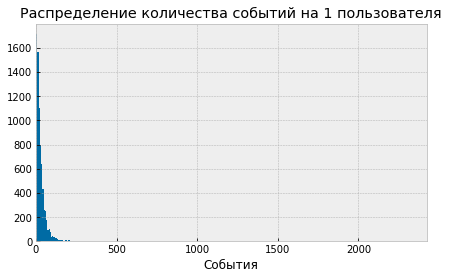

In [53]:
plt.figure(figsize=(7, 4))
user_event['events_per_user'].hist(bins=300, grid=True, )\
                             .set_title('Распределение количества событий на 1 пользователя')
plt.xlabel('События')
plt.xlim(0)
plt.show()

Данные скошены вправо - за среднее кол-во событий на 1 пользователя примем медиану данного распределения, которая равна 20.\
Посмотрим на наше распределение поближе.

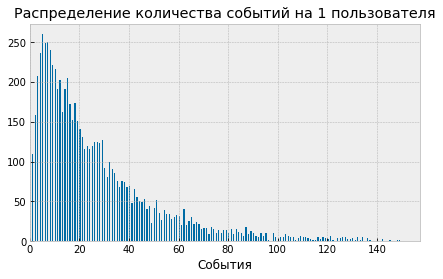

In [54]:
plt.figure(figsize=(7, 4))
user_event['events_per_user'].hist(bins=300, grid=True, range=[0, 150])\
                             .set_title('Распределение количества событий на 1 пользователя')
plt.xlim(0)
plt.xlabel('События')
plt.show()

Видим, что чаще всего на 1 пользователя приходится меньше 10 событий. Проверим свое предположение, найдя моду распределения.

In [14]:
print('Чаще всего пользователи совершают {} событий'.format(user_event['events_per_user'].mode()[0]))

Чаще всего пользователи совершают 5 событий


### Время.

Посмотрим за какой период нам представлены данные.

In [15]:
df['event_date'].describe()

count                  243713
unique                     14
top       2019-08-01 00:00:00
freq                    36141
first     2019-07-25 00:00:00
last      2019-08-07 00:00:00
Name: event_date, dtype: object

Данные представлены за период с 25.07.2019 по 07.08.2019, т.е. за 2 недели.\
Потроим график распределения.

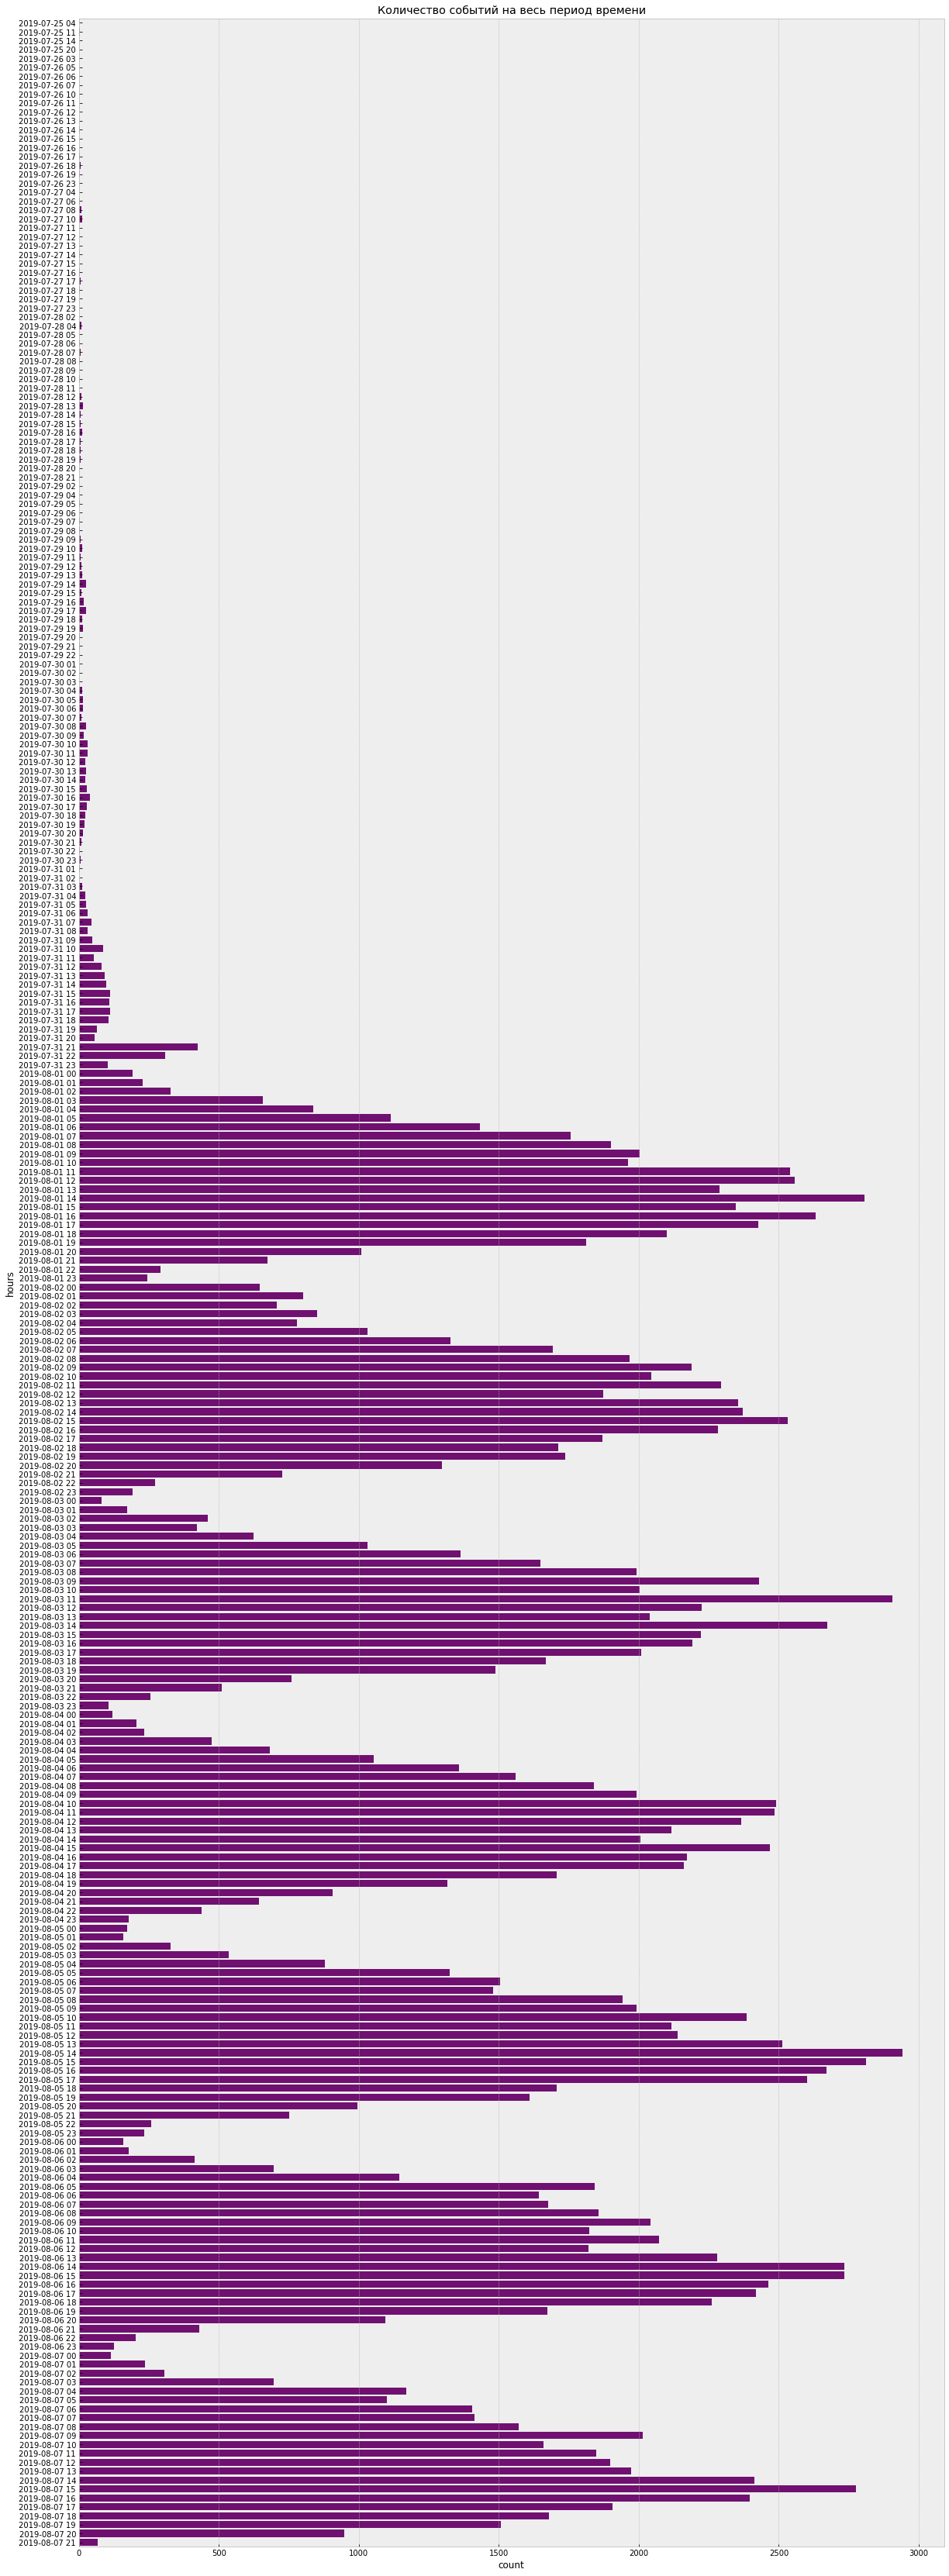

In [16]:
plt.figure(figsize=(20, 60))
ax = sns.countplot(y='hours', data=df, color='purple')
ax.set_title('Количество событий на весь период времени')
plt.show()

Судя по полученной гистограмме, начиная с 00 часов 01.08.2019 данные можем считать полными, и именно с этого периода будет корректнее рассматривать данные в дальнейшем, т.е., фактически, мы будем рассматривать данные за первую неделю августа. Видим, что данные за каждый день имеют нормальное распределение.

In [17]:
df_ = df.query('event_time >= "2019-08-01 00:00:00"')
df_.head()

,eventname,uid,event_time,group,event_month,event_date,hours
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,2019-08-01,2019-08-01 00
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,2019-08-01,2019-08-01 00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,2019-08-01,2019-08-01 00
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,2019-08-01,2019-08-01 00
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,2019-08-01,2019-08-01 00


Посмотрим на распределение наших усеченных данных:

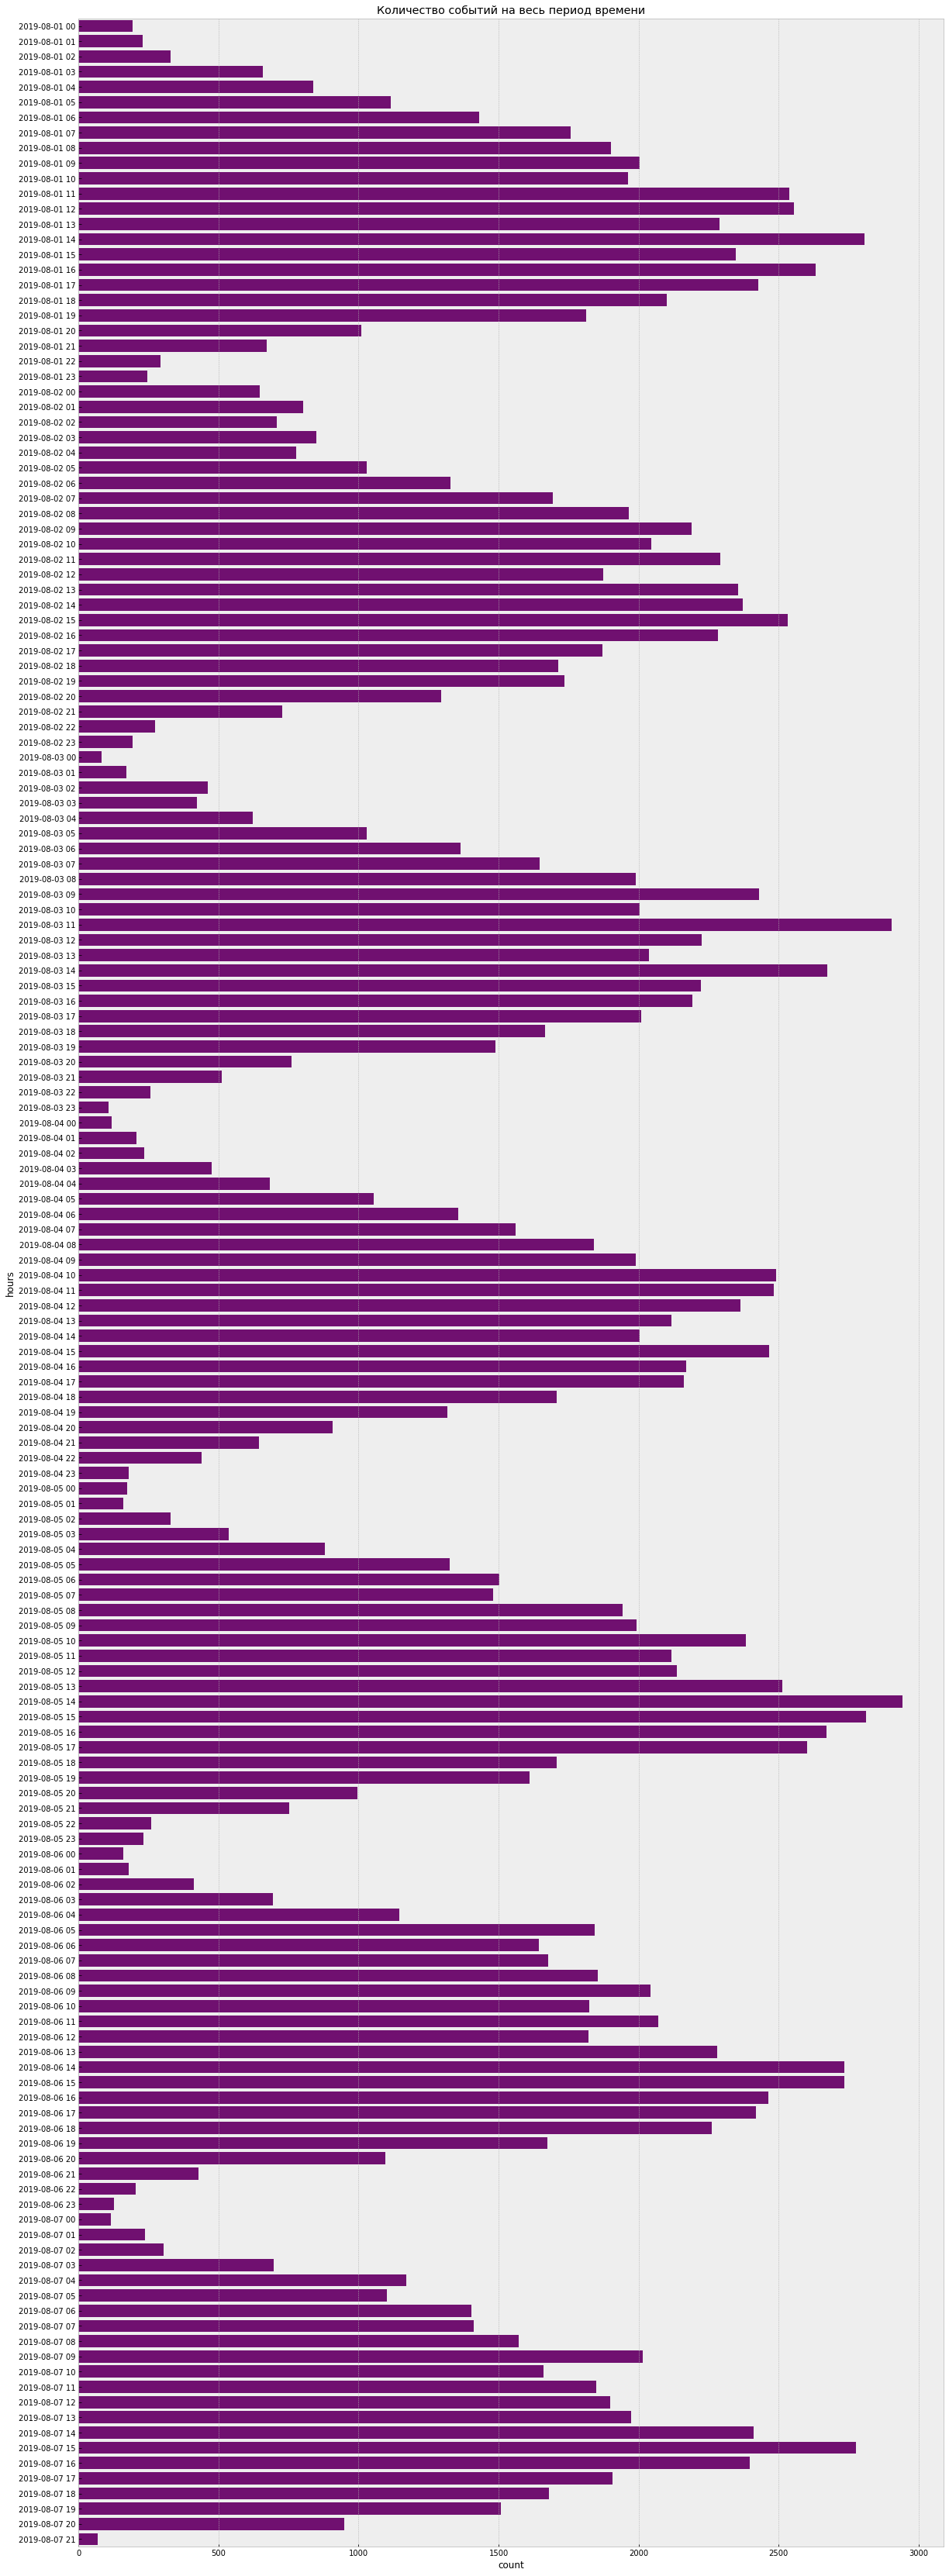

In [18]:
plt.figure(figsize=(20, 60))
ax = sns.countplot(y='hours', data=df_, color='purple')
ax.set_title('Количество событий на весь период времени')
plt.show()

Посмотрим как много данных потеряли мы, сократив их:

In [57]:
display(len(df))
display(len(df_))
display(len(df_) / len(df) * 100)

244126

240887

98.67322612093756

Наши данные составляют почти 99 % изначального кол-ва данных.\
Посмотрим также на число пользователей и число событий.

In [20]:
events_ = df_.groupby('eventname', as_index=False).agg({'uid': 'count'}).sort_values(by='uid', ascending=False)\
                                        .rename(columns={'uid':'count'})
events_['ratio'] = events_['count'] / events['count']
events_

,eventname,count,ratio
1,MainScreenAppear,117328,0.985113
2,OffersScreenAppear,46333,0.989852
0,CartScreenAppear,42303,0.991446
3,PaymentScreenSuccessful,33918,0.994138
4,Tutorial,1005,0.987230


In [21]:
display(df_['uid'].nunique())
display(df_['uid'].nunique() / df['uid'].nunique()*100)

7534

99.77486425638989

Данные по каждому из событий после сокращения составляют 99% изначального объема.\
Посмотрим, все ли группы у нас присутствуют в новом датасете.

In [22]:
group = df_.groupby('group', as_index=False).agg({'uid': 'nunique'})\
                                            .rename(columns={'uid':'count'})

group

,group,count
0,246,2484
1,247,2513
2,248,2537


Данная сводная таблица показывает нам наличие всех трех групп теста, а также их размер.

## Воронка событий

Еще раз посмотрим на данные сводной таблицы *events* (удалим ненужный в данном случае столбец *ratio*)

In [23]:
events_ = events_.drop('ratio', axis=1)
events_

,eventname,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Видим, что главный экран (*MainScreenAppear*) отображался за 1 неделю 117 328 раз, экран с заказами - 46 333 раз и т.д. Видим, что за неделю к разделу "Помощь" прибегали всего 1 005 раз.\
Посмотрим теперь сколько пользователй совершали каждое из данных событий - применим тот же принцип, что и для *events_*, но используем метод *nunique()* вместо *count()*.

In [24]:
events_by_user = df_.groupby('eventname', as_index=False).agg({'uid': 'nunique'}).sort_values(by='uid', ascending=False)\
                                        .rename(columns={'uid':'count'}).reset_index(drop=True)

events_by_user['ratio'] = (events_by_user['count'] / df_['uid'].nunique()*100).round(2)
events_by_user

,eventname,count,ratio
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Теперь видим, сколько пользователей совершили то или иное событие хотя бы раз, а также процент пользователей совершивших каждое из этих действий. \
Если пользователь, это тот, кто установил приложение, то 98,5% его открывали и попадали на главный экран. Остальные могли скачать приложение, но, просто еще не открывали его. Тогда 98,5% достаточно хороший показатель. Если же под "пользователем" мы подразумеваем человека, зарегистрировавшегося в приложении, то у 1,5% пользователей по каким-то причинам не открывается главный экран приложения. Стоит провести детальное изучение причин такого явления. Это могут быть пользователи, пытавшиеся зайти в приложение с одинакового устройства (планшет, например), а может быть это пользователи, из одной когорты, тогда надо посмотреть, что происходило с приложением в это время.\
61% пользователей переходили на страницу с заказами, следовательно остальные 39% не заинтересовались продукцией. Либо просто заходили в приложение, чтобы сравнить цены.\
Половина тех, кто попал на главную страницу приложения, проходили к корзине.\
Почти 47% оплачивали покупки в приложении.\
11% пользователей обращались к разделу помощи/инструкции.\
Визуализируем воронку событий:

In [58]:
fig = go.Figure(
                go.Funnel(
                            y = ["MainScreenAppear","OffersScreenAppear", "CartScreenAppear",\
                                 "PaymentScreenSuccessful", ],
                            x = [events_by_user['count'][0], events_by_user['count'][1], events_by_user['count'][2],\
                                 events_by_user['count'][3],], 
                        )
                    )

fig.update_layout(
                    title={
                            'text': "Воронка событий без учета последовательности",
                            'y':0.9,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'})

fig.update_traces(textinfo='label+text+percent initial', connector_fillcolor='purple', )
fig.show()

Итак, мы видим, что практически половина пользователей, побывавших на главном экране приложения, совершает покупку (48%). 62% пользователей после главного экрана переходят к заказам. На этапе оплаты заказа, часть пользователей отваливается - мы видим, что до корзины доходят 50%. Может быть сумма покупки недостаточна для бесплатной доставки, и поэтому пользователи не идут дальше, а может быть за время набора корзины повышается спрос на доставку и она становится платной (или дороже). Большая часть пользователей из экрана с корзиной проводят оплату заказа.\
Посчитаем время первого срабатывания каждого события по каждому из пользователей:

In [26]:
users = df_[df_['eventname'] != 'Tutorial']\
                .pivot_table(index='uid', columns='eventname', values='event_time', aggfunc='min')#.reset_index()
users.head()

eventname,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
uid,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


Даже при выводе первых пяти строк сводной таблицы видим, что в наших данных есть пользователи (например, пользователь с *uid = 6909561520679493*), у которых за рассматриваемый нами промежуток времени оплата (событие *PaymentScreenSuccessful*) произошла раньше события *OffersScreenAppear*. \
Найдем число пользователей, которые проходили поэтапно стадии *MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful*.\
Событие *Tutorial* не будем учитывать, точнее будем считать, что это совершение данного события и привело к тем значениям событий *OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful*, которые у нас сейчас имеются.

In [28]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

In [29]:
print('Число пользователей, попавших на главный экран:', users[step_1].shape[0])
print('Число пользователей, перешедших на экран с заказами:', users[step_2].shape[0])
print('Число пользователей, перешедших в корзину с заказами:', users[step_3].shape[0])
print('Число пользователей, перешедших на экран оплаты:', users[step_4].shape[0])

Число пользователей, попавших на главный экран: 7419
Число пользователей, перешедших на экран с заказами: 4201
Число пользователей, перешедших в корзину с заказами: 1767
Число пользователей, перешедших на экран оплаты: 454


In [60]:
fig = go.Figure(
                 go.Funnel(
                            y = ["MainScreenAppear","OffersScreenAppear", "CartScreenAppear",\
                                 "PaymentScreenSuccessful", ],
                            x = [users[step_1].shape[0], users[step_2].shape[0], users[step_3].shape[0],\
                                 users[step_4].shape[0],]
                ), )
fig.update_layout(
                    title={
                            'text': "Воронка событий с учетом последовательности",
                            'y':0.9,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'})
fig.update_traces(textinfo='label+text+percent previous', connector_fillcolor='purple')
fig.show()


Данный график отражает воронку последовательно происходящих событий.\
100% пользователй попадают на главный экран, т.е. наступает событие *MainScreenAppear*.\
Чуть больше половины посетителей главного экрана, а именно 55,6% проходит далее к заказам, и наступает событие *OffersScreenAppear*. Т.е. 44,4% пользователей не пожелали пройти дальше - по какой причине, не понятно. Это мог быть просто мониторинг цен наших продуктов, либо что-то помешало им пройти дальше.\
Почти 41% пользователей от заказа переходит к корзине - наступает событие *OffersScreenAppear*.\
26,9% пользователей предыдущего этапа совершают покупку. Получается, что 73% потенциальных покупателей не доводят действие до конца. На данном этапе могут скрываться проблемы разного рода: ошибка привязки карты или невозможность оплатить заказ картой; некорректность отображения корзины; отсутствие товаров на момент готовности пользователя оплатить заказ... \
Только 6% пользователей, последовательно совершивших события в указанном порядке, совершили заказ. Это говорит о том, что далеко не все пользователи ведут себя так, как мы предположили ранее. Не исключено, что попасть в корзину/совершить покупку можно просто перейдя по рекламной ссылке/баннеру, или как-то иначе.

## Обработка результатов эксперимента.

Дизайнеры приложения захотели произвести изменения со шрифтами, но у менеджеров продукта были некоторые опасения насчет этого - их беспокоила возможная негативная реакция пользователей. Поэтому было решено провести A/А/В-тест, где имеется 2 контрольные группы: 246 и 247, экспериментальная - 248.\
Посмотрим, на размеры групп:

In [31]:
group
#new_row = {'246&247': 5002}
group.loc[len(group)] = ['246&247', 5002]
group

,group,count
0,246,2484
1,247,2513
2,248,2537
3,246&247,5002


In [32]:
group_ = {246:2485,
          247:2517,
          248:2540,
         '246&247':5002}
group_['246&247']

5002

In [33]:
group_

{246: 2485, 247: 2517, 248: 2540, '246&247': 5002}

Сравним сначала 2 контрольные группы между собой на предмет статистической разницы между ними. Далее поочередно сравним обе контрольные группы с экспериментальной, после чего сравним объединенные контрольные группы в одну с экспериментальной. Итого мы имеем 4 сравнения, в каждом из которых существует еще и равнение между событиями, которых также 4. Следовательно, у нас проходит 16 сравнений, что ведет к следующему значению групповой вероятноятности ошибки 1-го рода:

In [34]:
1-(1-.05)**16

0.5598733313482347

Т.е., с вероятностью 56% мы можем получить ложнопозитивный результат в одном из 16 сравнений.\
Чтобы не допустить этого, применим поправку Бонферрони.\
Перед началом проверки гипотез сформулируем **H0: "Разница между 2-мя долями не является статистически значимой"**. \
Тогда **Н1 звучит так: "Разница между 2-мя долями является статистически значимой"**.\
Но сперва подготовим данные для проверки.

In [35]:
events = df_.groupby('eventname')['uid'].nunique().reset_index().rename(columns={'uid':'n_users'})

order = (events[events['eventname'] != 'Tutorial'].sort_values('n_users', ascending=False)['eventname']\
                                                  .reset_index(drop=True))
order

0           MainScreenAppear
1         OffersScreenAppear
2           CartScreenAppear
3    PaymentScreenSuccessful
Name: eventname, dtype: object

Отсортировали наши события в порядке убывания кол-ва пользователей их совершивших.\
Далее потготовим таблицу, которая отразит данный порядок событий по имеющимся группам, а также объединенной контрольной, которую нужно сравнить с экспериментальной.

In [36]:
groups = [246, 247, 248]
data = {}
for group in groups:
    data[group] = []
    for event in order:
        data[group].append(df_[(df_['group'] == group) & (df_['eventname'] == event)]['uid'].nunique())
        
data = pd.DataFrame(data)
data['246&247'] = data[246] + data[247]
data['eventname'] = order
data

,246,247,248,246&247,eventname
0,2450,2476,2493,4926,MainScreenAppear
1,1542,1520,1531,3062,OffersScreenAppear
2,1266,1238,1230,2504,CartScreenAppear
3,1200,1158,1181,2358,PaymentScreenSuccessful


In [37]:
data.index

RangeIndex(start=0, stop=4, step=1)

In [38]:
alpha = .05  # критический уровень статистической значимости
bonferroni_alpha = alpha / 16  # произведено 16 сравнений
#events = ["MainScreenAppear","OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"]
groups = [246, 247, 248, '246&247']

def z_test(group_one, group_two):
    for i in data.index:
        
        successes = np.array([data[group_one][i], 
                             data[group_two][i]])
        
        trials = np.array([group_[group_one], 
                           group_[group_two]])
        
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(data['eventname'][i], 'p-значение: ', p_value)

        if p_value < bonferroni_alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [39]:
z_test(246, 247)

MainScreenAppear p-значение:  0.5238975433084909
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear p-значение:  0.22748768504512773
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear p-значение:  0.21319490429545773
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful p-значение:  0.10588523043189935
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни в одном из этапов разница между группами не является статистически значимой, а значит, разбиение на 2 контрольные группы работает корректно.\
Проверим экспериментальную группу с двумя контрольными поочередно, а затем и совместно.

In [40]:
z_test(246, 248)

MainScreenAppear p-значение:  0.2163595068969486
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear p-значение:  0.19637342991304285
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear p-значение:  0.07399762051680359
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful p-значение:  0.20296278942354062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [41]:
z_test(247, 248)

MainScreenAppear p-значение:  0.5470373177885279
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear p-значение:  0.9341037836249468
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear p-значение:  0.5886125260182358
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful p-значение:  0.7273485915065132
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [42]:
z_test('246&247', 248)

MainScreenAppear p-значение:  0.2834519123814019
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear p-значение:  0.42919664172399585
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear p-значение:  0.17959307399415048
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful p-значение:  0.5957420671734721
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Итак, во всех 16 случаях разница между долями не является статистически значимой. Т.е. зря менеджеры продукта опасались негативной реакции пользователей на изменение шрифта сайта.\
Посмотрим как, изменились бы наши показатели при уровне значимости, равному 0.1

In [43]:
1-(1-.1)**16

0.8146979811148158

Т.е., с вероятностью 81% мы можем получить ложнопозитивный результат в одном из 16 сравнений при данном уровне статистической значимости.

## Выводы

Нам были предоставлены данные за период с 25.07.2019 по 07.08.2019, из которого был выбран промежуток времени с наиболее полными данными, подходящими для анализа:  с 10 часов 31.07.2019 до 21 часа 07.08.2019.\
Всего за выделенный промежуток времени было совершено 242695 события 7542 пользователями.\
47% польователей доходят до финальной стадии - оплаты заказа, однако, если рассматривать путь пользователя в приложении как последовательное прохождение через стадии MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful, то доля покупателей сократится до 27%.\
При сравнении показателей 2-х контрольных груп, каждой из контрольных групп с экспериментальной, объединенных контрольных групп с экспериментальной не была выявлена статистически значимая разница между ними.